In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import ndimage
import glob
from tqdm import tqdm
import pickle
import cv2
from skeleton import skeleton
G, color_edge = skeleton()

In [2]:
home_dir = '/data/LiftFly3D/optobot/'

experiments = ['fly1_pre_stimulationDeepCut_resnet50_dlcTrackingAug6shuffle1_1030000.h5']
joints = ['RFbodyCoxa', 'RFfemurTibia', 'RFtibiaTarsus', 'RFclaw',
          'RMbodyCoxa', 'RMfemurTibia', 'RMtibiaTarsus', 'RMclaw',
          'RHbodyCoxa', 'RHfemurTibia', 'RHtibiaTarsus', 'RHclaw',
          'LFbodyCoxa', 'LFfemurTibia', 'LFtibiaTarsus', 'LFclaw', 
          'LMbodyCoxa', 'LMfemurTibia', 'LMtibiaTarsus', 'LMclaw',
          'LHbodyCoxa', 'LHfemurTibia', 'LHtibiaTarsus', 'LHclaw']
ids = [0, 2, 3, 4, 5, 7, 8, 9, 10, 12, 13, 14, 15, 17, 18, 19, 20, 22, 23, 24, 25, 27, 28, 29]

Filter for high quality frames

In [9]:
for i in tqdm(range(len(experiments))):
    data = pd.read_hdf(home_dir + experiments[i]) #load data
    data = data.droplevel('scorer',axis=1) #drop scorer column label

    #convert & save to DF3D format
    data_np = data.loc[:,(joints,['x','y'])].to_numpy()
    
    #rotate flies pointing right
    theta = np.radians(90)
    cos, sin = np.cos(theta), np.sin(theta)
    R = np.array(((cos, -sin), (sin, cos)))
    
    data_np = data_np.reshape(-1,2)
    data_np = np.matmul(data_np - 80,R) + 80
    data_np = data_np.reshape(-1,2*len(joints))
    data_np = np.stack((data_np[:,::2], data_np[:,1::2]), axis=2)
    
    poses = {'points2d': data_np}
    
    #import sys
    #sys.exit()
    
    #save
    pickle.dump(poses,open(home_dir + experiments[i][:-3] + '.pkl', 'wb'))

100%|██████████| 1/1 [00:00<00:00, 117.82it/s]


In [4]:
data_np.shape

(80, 24, 2)

In [5]:
def video_to_imgs(vid_path):
    '''Convert video to a list of images'''
    
    cap = cv2.VideoCapture(vid_path)         
    imgs = []            
    while True:
        flag, frame = cap.read()
        if flag:                            
            imgs.append(frame)       
        else:
            break        
    
    return imgs


def plot_skeleton(x, y, ids, color_edge, ax=None):
           
    coords_x, coords_y = np.zeros(len(G.nodes)), np.zeros(len(G.nodes))
    coords_x[ids] = x
    coords_y[ids] = y
    
    for i, j in enumerate(G.edges()): 
        if j[0] in ids and j[1] in ids:
            u = np.array((coords_x[j[0]], coords_x[j[1]]))
            v = np.array((coords_y[j[0]], coords_y[j[1]]))
            if ax is not None:
                ax.plot(u, v, c=color_edge[j[0]], alpha=1.0, linewidth = 2)
            else:
                plt.plot(u, v, c=color_edge[j[0]], alpha=1.0, linewidth = 2)

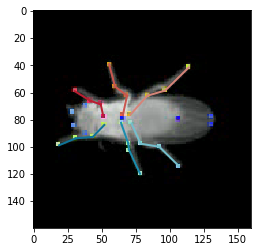

In [6]:
imgs = video_to_imgs(home_dir + experiments[0][:-3] + '_labeled.mp4')
#imgs = video_to_imgs(home_dir + 'fly1_pre_stimulation.mp4')
data = pickle.load(open(home_dir + experiments[0][:-3] + '.pkl','rb'))
poses = data['points2d']

f= plt.figure()
im_rot = ndimage.rotate(imgs[0],90)
plt.imshow(im_rot,cmap='gray', vmin=0, vmax=255)
plot_skeleton(poses[0,:,0],poses[0,:,1],ids, color_edge)

In [8]:
data['points2d'].shape

(80, 24, 2)